## Pre-trained word embeddings: exercise YELP

Yelp is a review website (see e.g. https://nl.yelp.be/search?find_desc=&find_loc=gent&ns=1)

- The file yelp_labelled.txt contains reviews. 
- If Label = 0, it's a review with a negative sentiment. 
- If Label = 1, it's a review with a positive sentiment.   

Create an ANN model to predict the sentiment.
  
Filter out those reviews that aren't in English first.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D,  MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.constraints import max_norm
from keras.models import load_model


import nltk


2.9.1


In [2]:
# helper functions for visualisation
# plotting the loss functions used in this notebook
# we plot the loss we want to optimise on the left (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/yelp_labelled.txt",sep="\t") 
data.head()


,Text,Label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Show the statistical information about the data.

In [4]:
data.describe()

,Label
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1000 non-null   object
 1   Label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Is this a skewed dataset?

In [5]:
data['Label'].value_counts()

1    500
0    500
Name: Label, dtype: int64

In [6]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print ('You are running on Google Colab')
    !pip install langdetect
else:
    colab = False
    print ('You are not running on Google Colab')

You are not running on Google Colab


Remove those Text's that are not in English (see list below for all non-English texts).

In [16]:
from langdetect import detect
data['Text'] = data['Text'].astype("string")
data['Language'] = data['Text'].apply(detect)
data_en = data.query("Language == 'en'")
rest = data.query("Language != 'en'")
rest.head()
#data.head()

,Text,Label,Language
19,did not like at all.,0,af
93,Best breakfast buffet!!!,1,de
109,Sooooo good!!,1,so
117,I've had better atmosphere.,0,no
131,Penne vodka excellent!,1,fr


How many records are left?

In [17]:
data_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      958 non-null    string
 1   Label     958 non-null    int64 
 2   Language  958 non-null    object
dtypes: int64(1), object(1), string(1)
memory usage: 29.9+ KB


## Using pre-trained word embeddings

What is the average length of the Text's (expressed as a number of words). This will be important when we need to truncate the sequences to a maximum length?  
75% of the blogs consist of how many words?

In [18]:
data_en['numberOfWords'] = data_en.Text.str.split().apply(len)
data_en.head()

C:\Users\bart.de.paepe\AppData\Local\Temp\ipykernel_21628\2752354257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_en['numberOfWords'] = data_en.Text.str.split().apply(len)


,Text,Label,Language,numberOfWords
0,Wow... Loved this place.,1,en,4
1,Crust is not good.,0,en,4
2,Not tasty and the texture was just nasty.,0,en,8
3,Stopped by during the late May bank holiday of...,1,en,15
4,The selection on the menu was great and so wer...,1,en,12


In [19]:
data_en.describe()

,Label,numberOfWords
count,958.000000,958.000000
mean,0.502088,11.176409
std,0.500257,6.217512
min,0.000000,2.000000
25%,0.000000,6.000000
50%,1.000000,10.000000
75%,1.000000,15.000000
max,1.000000,32.000000


What is X_train, y_train, X_test, y_test?

In [22]:
# Extract a training & validation split
from sklearn.model_selection import train_test_split
X = data_en.drop(['Label','Language','numberOfWords'],axis=1)
y = data_en['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(type(X_train))

X_train shape: (766, 1)
X_test shape: (192, 1)
766 train samples
192 test samples
<class 'pandas.core.frame.DataFrame'>


What is X_train, y_train, X_val, y_val?

In [23]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.20,random_state=42)

What are the dimensions of X_train, X_val, X_test, y_train, y_val, y_test?

In [24]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

X_train shape: (612, 1)
X_val shape: (154, 1)
X_test shape: (192, 1)
y_train shape: (612,)
y_val shape: (154,)
y_test shape: (192,)


Transform X_train, X_val and X_test into an array

In [25]:
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)

print('X_train shape:', X_train.shape)
print(type(X_train))

X_train shape: (612, 1)
<class 'numpy.ndarray'>


Look at the new labels for the first sample.

In [26]:
# look at the new labels for the first sample
print(y_train[0])
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

1
y_train shape: (612,)
y_val shape: (154,)
y_test shape: (192,)


### Create a vocabulary index

Use the TextVectorization to index the vocabulary found in the dataset. Later, the same layer instance will be used to vectorize the samples.

The layer will only consider the top 20,000 words, and will truncate or pad sequences to be actually 15 tokens long (75% quartile).

In [27]:

from keras.layers import TextVectorization

# max_tokens = integer parameter that will control the maximum size of the vocabulary.
# We will only consider the top 20 000 words
# output_sequence_length = 25: we will truncate or pad sequences to be actually 25 tokens long.
# This is the reason why we calculated the number of words for each message in a previouse step
# From the describe we learn that 75% of the messages are not longer than 23 tokens
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=15)

# Make a Dataset from a numpy array
# A tf.data.Dataset represents a potentially large set of elements.
text_ds = tf.data.Dataset.from_tensor_slices(X_train)

# Call the adapt method to build the vocabulary
vectorizer.adapt(text_ds)

You can retrieve the computed vocabulary used via vectorizer.get_vocabulary().  
Let's print the top 5 words

In [28]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'i']

Vectorize a small sentence "the girl was unhappy" 

In [29]:
output = vectorizer([["the girl was unhappy"]])
print(type(output))
output.numpy()[0, :4]

<class 'tensorflow.python.framework.ops.EagerTensor'>


array([2, 1, 5, 1], dtype=int64)

By which number is i represented? And girl? 
Give the dict mapping words to their indices.

In [31]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [32]:
test = ["the","girl","was", "unhappy"]
[word_index[w] for w in test]

KeyError: 'girl'

### Load pre-trained word embeddings


Make a dict mapping words (strings) to their NumPy vector representation. Use the 100-dimensional vectors.

In [33]:
path_to_glove_file = '../datasets/glove.6B.100d.txt'

embeddings_index = {}

with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:

      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


What is the embeddings_vector for the word girl?

In [34]:
embedding_vector = embeddings_index.get('girl')
embedding_vector

array([ 7.4582e-01,  1.9531e-01,  4.6831e-01, -1.0277e-01, -2.9927e-01,
        9.9653e-01,  1.3940e-01,  6.4173e-01,  3.3129e-01,  3.5322e-01,
       -3.0205e-01,  3.4699e-01,  5.3364e-01,  6.2235e-01,  4.3555e-01,
        5.4403e-01,  3.9656e-01, -3.1789e-01, -2.0172e-01,  9.9636e-01,
        1.8479e-03, -1.4826e-01, -4.1845e-03,  2.4953e-01,  3.0177e-01,
        1.0043e+00, -4.4867e-01, -1.2911e+00, -1.2741e-01,  9.0103e-01,
        1.1870e-01,  2.7229e-01,  9.7697e-01,  1.9520e-02,  4.0453e-01,
       -6.1585e-01, -5.0483e-01, -3.1174e-02,  7.0384e-01, -4.6058e-01,
       -4.3899e-01,  4.2115e-01, -1.7343e-01, -4.1879e-01,  7.4560e-03,
        2.6609e-01, -7.8183e-01,  4.5464e-01,  9.0846e-01, -1.3126e-01,
       -4.8101e-01, -2.4726e-01,  2.9251e-01,  1.4122e+00,  2.5368e-02,
       -1.9882e+00, -5.3257e-01,  1.3427e-01,  8.8987e-01,  6.7416e-01,
        7.3902e-01,  1.0998e+00, -7.6633e-01, -8.4833e-04,  5.0982e-01,
        1.9587e-01,  7.1845e-01,  2.5045e-01, -2.9609e-01,  1.90

Prepare a corresponding embedding matrix that can be ued in a Keras Embedding layer. It's a simple NumPy matrix where the entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [35]:
num_tokens = len(voc) + 2
# each word is represented by a vector of 100 floats (glove.6B.100d.txt)
embedding_dim = 100
hits = 0
misses = 0
missed_words = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# word_index is a dictionary that maps each word to an index
# we loop through all the words of word_index.items()
# the items() method of a dictionary returns a list of tuples (key, index) for all elements in the dictionary
for word, i in word_index.items():
# we try to retrieve the vector of 100 floats for this word out of embeddings_index
    embedding_vector = embeddings_index.get(word)
# if we found the corresponding vector of 100 floats
    if embedding_vector is not None:
      # we put the vector on position i of embedding_matrix
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
      # Words not found in embedding index will be all-zeros.
        misses += 1
        missed_words.append(word)

print("Converted %d words (%d misses)" % (hits, misses))

print("*** shape of the embedding matrix:***")
print(embedding_matrix.shape)

print("*** Missed words = words not in word_index ***")
print(missed_words[0:10])
print()

Converted 1557 words (65 misses)
*** shape of the embedding matrix:***
(1624, 100)
*** Missed words = words not in word_index ***
['', '[UNK]', 'yaall', 'wouldve', 'worstannoying', 'workingeating', 'werent', 'wayyy', 'waaaaaayyyyyyyyyy', 'veggitarian']



### Build the model
First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

In [37]:
X_train_final = vectorizer(np.array([s for s in X_train])).numpy()
X_test_final = vectorizer(np.array([s for s in X_test])).numpy()

y_train_final = np.array(y_train)
y_test_final = np.array(y_test)
print(X_train.shape)
print(X_test.shape)
print(X_train_final.shape)
print(X_test_final.shape)
print('----------------')
print(y_train_final.shape)
print(y_test_final.shape)

(612, 1)
(192, 1)
(612, 15)
(192, 15)
----------------
(612,)
(192,)


[[   4  189   71    7   41   32    0    0    0    0    0    0    0    0
     0]
 [  92 1096   34  205 1583    3    9    5    2   95    3  223   44   92
   788]
 [   2   11    8   13  139   36   38   13    7   98  102  337  721 1163
   427]
 [   2 1435   23   50    3   96    6   14  277    0    0    0    0    0
     0]
 [   4   21  360 1170   16    9   17  205    2 1465   30  237  218    6
   595]]


Create a small ANN model to predict the Label. Load the pre-trained word embeddings matrix into an Embedding layer.

Compile the model.

Train the model.

Evaluate the model

In [38]:
# restart your ANN befor retraining!
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
num_classes = 2

def initial_model():
    # we create a variable called model, and we set it equal to an instance of a Sequential object.
    model = Sequential()

    model.add(Embedding(input_dim=num_tokens, output_dim=embedding_dim, input_length=15,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False))
    model.add(keras.layers.Flatten(input_shape=[num_tokens, embedding_dim]))

    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(Dense(num_classes, activation='softmax'))


    # Before we can train our model, we must compile it
    # To the compile() function, we are passing the optimizer, the loss function, and the metrics that we would like to see.
    # Notice that the optimizer we have specified is called Adam. Adam is just a variant of SGD.
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01),
                  metrics=['accuracy'])
    return model

In [43]:
model_1 = initial_model()
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 100)           162400    
                                                                 
 flatten_1 (Flatten)         (None, 1500)              0         
                                                                 
 dense_5 (Dense)             (None, 100)               150100    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 100)              

In [44]:
batch_size = 64
epochs = 20

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)



history_1 = model_1.fit(X_train_final, y_train_final,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_final, y_test_final),
                    callbacks=[early_stopping_cb]
                    )

Epoch 1/20
10/10 [==============================] - 1s 16ms/step - loss: 2.5014 - accuracy: 0.4951 - val_loss: 1.1217 - val_accuracy: 0.5260
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 1.3475 - accuracy: 0.5131 - val_loss: 0.7634 - val_accuracy: 0.5208
Epoch 3/20
10/10 [==============================] - 0s 5ms/step - loss: 1.0202 - accuracy: 0.5261 - val_loss: 0.7837 - val_accuracy: 0.4844
Epoch 4/20
10/10 [==============================] - 0s 6ms/step - loss: 0.8327 - accuracy: 0.5065 - val_loss: 0.6832 - val_accuracy: 0.5781
Epoch 5/20
10/10 [==============================] - 0s 5ms/step - loss: 0.7018 - accuracy: 0.5882 - val_loss: 0.6828 - val_accuracy: 0.5521
Epoch 6/20
10/10 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5882 - val_loss: 0.6538 - val_accuracy: 0.6562
Epoch 7/20
10/10 [==============================] - 0s 5ms/step - loss: 0.6558 - accuracy: 0.5980 - val_loss: 0.6408 - val_accuracy: 0.6042
Epoch 8/20
10/10 [=

Training set Accuracy:   0.73
Training set Loss: 0.5510

Validation set Accuracy:   0.60
Validation set Loss: 0.6408



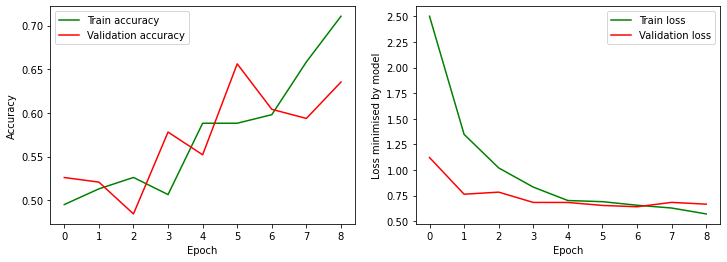

In [45]:
[train_loss, train_accuracy] = model_1.evaluate(X_train_final, y_train_final, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(X_test_final, y_test_final, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)